# Product Detail Agent

A conversational AI agent built with LangGraph that provides product information in Nepali-English mixed language (Romanized Nepali). The agent intelligently searches through a product catalog and responds to customer queries in a natural, culturally appropriate manner.

## Overview

This agent uses LangChain's agentic framework (LangGraph) to create a tool-calling workflow that can:
- Understand customer queries in mixed Nepali-English
- Search product catalogs from Google Sheets
- Provide accurate pricing and stock information
- Communicate naturally in Romanized Nepali

## Architecture

### Components

**State Management**
- Uses `TypedDict` with message accumulation via `add_messages`
- Maintains conversation context across multiple turns

**LLM Integration**
- Model: `openai/gpt-oss-120b` via Groq
- Temperature: 0 (deterministic responses)
- Tool-calling enabled for structured interactions

**Workflow Graph**
```
START → agent → [tool_condition] → tools → agent → END
                      ↓
                     END
```

### Key Features

1. **Dynamic Product Search**
   - Connects to Google Sheets via CSV export URL
   - Uses LLM-powered semantic matching for product names
   - Returns structured JSON with product details

2. **Cultural Localization**
   - Communicates in Romanized Nepali (Nepali + English)
   - Understands local terminology (e.g., "moja/mojja" = socks)
   - Short, concise responses suitable for messaging platforms

3. **Tool Integration**
   - `search_catalog` tool for product lookups
   - Automatic tool invocation based on conversation context
   - Graceful handling of "product not found" scenarios

## Implementation Details

### Tool Definition

```python
@tool
def search_catalog(product_name: str) -> str:
    """
    Search the product catalog for price and stock details.
    Uses LLM to reason over CSV content.
    """
    df = pd.read_csv(SHEET_URL)
    
    prompt = f"""
    You are a product finder.
    User is asking for: {product_name}
    
    Here is the product catalog (CSV):
    {df.to_csv(index=False)}
    
    Task:
    - Find the closest matching product by meaning
    - Return ONLY valid JSON
    - JSON format:
      {{
        "name": "...",
        "price": "...",
        "stock": "..."
      }}
    
    If product not found, return:
    {{"found": false}}
    """
    
    result = llm.invoke(prompt)
    return result.content
```

### System Prompt

The agent operates with the following instructions:
- Act as a helpful sales assistant for a clothing business
- Communicate in Romanized Nepali (Nepali + English mix)
- Understand local terminology ("moja" = socks)
- Use `search_catalog` tool for product inquiries
- Keep responses short and concise
- Politely inform customers if products are unavailable

### Agent Node

```python
def agent(state: State):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
```

## Use Cases

### 1. **E-Commerce Customer Support**
Perfect for small to medium Nepali businesses running online stores:
- WhatsApp Business automation
- Facebook Messenger integration
- Website chatbots
- SMS-based ordering systems

**Example Interaction:**
```
Customer: "Jutta cha?"
Agent: "Jutta (juta) cha! Price Rs. 1,600 ra stock ma 30 units baki cha."
```

### 2. **Retail Inventory Assistant**
Help retail staff quickly check product availability:
- In-store inventory lookups
- Real-time stock checking
- Price verification
- Product recommendation

### 3. **Multi-Language Product Discovery**
Bridge language gaps for diverse customer bases:
- Handle mixed language queries
- Understand local product terminology
- Semantic product matching (handles typos, variations)

### 4. **Marketplace Integration**
Connect to existing e-commerce platforms:
- Daraz, SastoDeal integration
- Facebook Marketplace automation
- Instagram Shopping assistance

### 5. **Order Management**
Extend to handle complete order workflows:
- Product inquiry → Stock check → Order placement
- Automated order confirmations
- Delivery status updates

### 6. **Business Analytics**
Collect data through conversations:
- Most queried products
- Stock-out frequency
- Customer preference patterns
- Regional language preference insights

## Technical Requirements

### Dependencies

```python
pandas              # Data manipulation
langchain_groq      # LLM integration
langchain_core      # Core LangChain components
langgraph           # Agentic workflow framework
python-dotenv       # Environment management
```

### Environment Setup

```bash
# .env file
GROQ_API_KEY=your_api_key_here
```

### Data Source

Product catalog format (Google Sheets):
```csv
name,price,stock
Jutta,1600,30
Moja,200,50
T-shirt,800,100
```

## Running the Agent

### Basic Usage

```python
from langchain_core.messages import HumanMessage

# Single query
result = app.invoke({
    "messages": [HumanMessage(content="jutta ko price kati?")]
})

# Streaming conversation
events = app.stream(
    {"messages": [HumanMessage(content="moja cha?")]},
    stream_mode="values"
)

for event in events:
    message = event["messages"][-1]
    if message.type == "ai" and not message.tool_calls:
        print(f"Assistant: {message.content}")
```

### Interactive Loop

```python
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit"]:
        break
        
    events = app.stream(
        {"messages": [HumanMessage(content=user_input)]},
        stream_mode="values"
    )
    
    for event in events:
        message = event["messages"][-1]
        if message.type == "ai" and not message.tool_calls:
            print(f"Assistant: {message.content}")
```

## Advantages

### Technical Benefits
- **Stateful Conversations**: Maintains context across multiple turns
- **Tool Integration**: Easy to add new tools (payment, shipping, etc.)
- **Error Handling**: Graceful degradation when products not found
- **Scalable**: Can handle multiple concurrent conversations

### Business Benefits
- **Cost Effective**: Reduces need for human customer service agents
- **24/7 Availability**: Always ready to assist customers
- **Language Flexibility**: Adapts to customer's language preference
- **Quick Setup**: Connect to existing inventory spreadsheets
- **Insights**: Built-in conversation logging for analytics

## Customization

### Adding New Tools

```python
@tool
def check_delivery(pincode: str) -> str:
    """Check if delivery available to customer location"""
    # Implementation
    pass

tools = [search_catalog, check_delivery]
llm_with_tools = llm.bind_tools(tools)
```

### Modifying Language Style

Adjust the system prompt to change communication style:
- Formal vs. casual tone
- Pure Nepali vs. Romanized Nepali
- Technical vs. simple language

### Connecting Different Data Sources

Replace the Google Sheets connection with:
- Database queries (PostgreSQL, MySQL)
- REST API calls
- Local CSV/Excel files
- Cloud storage (S3, Google Cloud Storage)

## Limitations & Future Enhancements

### Current Limitations
- Requires internet connection for LLM calls
- Limited to text-based interactions
- No payment processing integration
- Basic product matching (exact/semantic only)

### Potential Enhancements
1. **Voice Support**: Add speech-to-text/text-to-speech
2. **Image Recognition**: Handle product photos from customers
3. **Payment Integration**: Connect to eSewa, Khalti, etc.
4. **Multi-Channel**: Deploy across WhatsApp, Viber, Messenger
5. **Analytics Dashboard**: Visualize conversation metrics
6. **Memory System**: Remember customer preferences
7. **Recommendation Engine**: Suggest products based on history

## Deployment Options

### 1. Local Development
Run directly on your machine for testing

### 2. Cloud Functions
Deploy as serverless functions:
- AWS Lambda
- Google Cloud Functions
- Azure Functions

### 3. Container Deployment
Dockerize for consistent environments:
- Docker + Kubernetes
- Google Cloud Run
- AWS ECS

### 4. Messaging Platform Integration
Direct integration with:
- WhatsApp Business API
- Facebook Messenger API
- Telegram Bot API
- Viber Business Messages

## Conclusion

This Product Detail Agent demonstrates how agentic AI systems can be tailored for specific regional markets and business needs. By combining tool-calling capabilities with cultural awareness, it provides an effective solution for Nepali businesses looking to automate customer interactions while maintaining a natural, localized experience.

The modular architecture makes it easy to extend functionality, integrate with existing systems, and scale as business needs grow.

In [47]:

import pandas as pd
from typing import Annotated, Literal, TypedDict

from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
load_dotenv()
llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

In [ ]:

SHEET_URL = "https://docs.google.com/spreadsheets/d/1UMMGxfYsG9VmeYJS0Ehn9sEHCsB4KjfIK7f6c7py_eo/export?format=csv&gid=0"


In [ ]:

@tool
def search_catalog(product_name: str) -> str:
    """
    Search the product catalog for price and stock details.
    Uses LLM to reason over CSV content.
    """

    # Load the sheet data
    df = pd.read_csv(SHEET_URL)

    prompt = f"""
You are a product finder.

User is asking for: {product_name}

Here is the product catalog (CSV):
{df.to_csv(index=False)}

Task:
- Find the closest matching product by meaning
- Return ONLY valid JSON
- JSON format:
  {{
    "name": "...",
    "price": "...",
    "stock": "..."
  }}

If product not found, return:
{{"found": false}}
"""

    result = llm.invoke(prompt)
    return result.content

In [ ]:

class State(TypedDict):
    messages: Annotated[list, add_messages]



# Bind tools to the LLM
tools = [search_catalog]
llm_with_tools = llm.bind_tools(tools)


# Define the System Prompt (from your n8n Agent node)
sys_msg = SystemMessage(content="""You are a helpful sales assistant for a clothing business.
You communicate in latent romanized nepali (mixture of nepali and english).

Your task is to:
1. Understand customer questions about products (note: "moja" or "mojja" means socks)
2. Use the search_catalog tool to find product details
3. Respond in romanized Nepali (mixture of Nepali and English)
4. Keep responses short and concise
5. If a product is not found, politely inform the customer""")

In [51]:


# Define the Agent Node
def agent(state: State):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# --- 5. BUILD THE GRAPH ---
workflow = StateGraph(State)

# Add nodes
workflow.add_node("agent", agent)
workflow.add_node("tools", ToolNode(tools))

# Add edges
workflow.add_edge(START, "agent")

# Conditional edge: If tool called -> Go to tools, Else -> End
workflow.add_conditional_edges(
    "agent",
    tools_condition,
)

# Return from tools back to agent to generate the final answer
workflow.add_edge("tools", "agent")

# Compile the graph
app = workflow.compile()

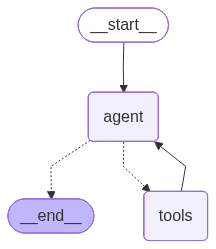

In [52]:
app

In [53]:


# --- 6. RUN THE WORKFLOW ---
if __name__ == "__main__":
    print("--- Nepali Sales Assistant Started ---")
    
    while True:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit"]:
            break
            
        # Stream the output
        events = app.stream(
            {"messages": [HumanMessage(content=user_input)]},
            stream_mode="values"
        )
        
        for event in events:
            message = event["messages"][-1]
            if message.type == "ai" and not message.tool_calls:
                print(f"Assistant: {message.content}")

--- Nepali Sales Assistant Started ---
Assistant: Namaste! Kasto cha? Ke help garna sakchu?
Assistant: Jutta (juta) cha! Price Rs. 1,600 ra stock ma 30 units baki cha. Kunu arko cha bhane janau na.
